# Example of loading, and running the Dark Treasure Room Models

In [1]:
import os  # ensure we can import the lte_code
import sys
sys.path.append(os.getcwd()+"/..")
sys.path


script_setting = {'roomsize' : 9,
                  'batchsize' : 128,
                  'weighting' : True,
                  'seed' : 1,
                  'k' : 8,
                  't' : 1}


run_name = ''.join((f"{key}_{script_setting[key]}" for key in script_setting.keys()))
checkpoint_dir = run_name

### From Notebook:

from lte_code.bandit import Bandit
import jax
import jax.numpy as jnp
ACT_DIM = 5
from lte_code.lte_model5 import LTE
from transformers import DecisionTransformerConfig

config = DecisionTransformerConfig(act_dim=ACT_DIM, state_dim=2,
                                   n_head=4, n_layer=4, hidden_size=128)
num_training_steps = 1000*500


import optax
def warmup_linear_schedule(
    learning_rate: float,
    total_steps: int,
    warmup_ratio: int):
    warmup_steps = int(total_steps*warmup_ratio)
    schedules = [
      optax.linear_schedule(
          init_value=0,
          end_value=learning_rate,
          transition_steps=warmup_steps),
      optax.linear_schedule(
          init_value=learning_rate,
          end_value=0,
          transition_steps= total_steps - warmup_steps),]
    return optax.join_schedules(schedules, [warmup_steps])


schedule = warmup_linear_schedule(learning_rate=1e-4,
                                  total_steps=num_training_steps,
                                  warmup_ratio=0)
optimizer = optax.chain(
  optax.clip(0.25),
  optax.adamw(learning_rate=schedule, weight_decay=1e-4),
)

model = LTE(config)
key = jax.random.PRNGKey(0)
pkey, key = jax.random.split(key)
batch_size=1000

from darkroom.darkroomofbandits import BatchedDarkRoom, save_rollout_multi_gif

# print("Kind Room ATM")
print("Treasure Room ATM")
env = BatchedDarkRoom(w=script_setting['roomsize'],
                      h=script_setting['roomsize'],
                      batch_size=batch_size, k=script_setting['k'],
                      rand_start=False,
                      minval=-4)
batch_step = env.step
batch_mset = env.meta_reset

STATE_DIM = 2
ACT_DIM = 5

def rollout_sequence(states, actions):
    """takes a batch of states
    and a batch of actions [batch_dim, seq_len, act_dim]
    and calculates the rewards, [batch_dim, seq_len, rewards]"""
    def step_state_reward(state, action):
        state = batch_step(state, action)
        return state, (state.obs, state.reward)
    states, x = jax.lax.scan(step_state_reward,
                                   states,
                                   jnp.swapaxes(actions, 0, 1))
    obs, rewards = jax.tree_map(lambda a: jnp.swapaxes(a, 0, 1), x)
    return obs, rewards

def tokenize(actions_batch, rewards_batch):
    @jax.vmap
    @jax.vmap
    def one_hot(act):
        return jnp.zeros(shape=ACT_DIM).at[act].set(1)
    action_tokens = one_hot(actions_batch)
    return action_tokens, jnp.expand_dims(rewards_batch, 2)

### Functions for autoregressive sampling

from flax.core.frozen_dict import unfreeze, freeze
def feed_token(model_params, cache,
               obs, rewards, actions,
               timesteps, ep_nums):
    """takes the parameters, the current model cache,
    the token, token_type, and time_step
    and feeds them to the model updating the cache
    
    Note, can process multiple tokens at once
    token should be [batch_size, seq_len, token_dim]
    and token_type [batch_size, seq_len]
    time_step [batch_size, seq_len]"""
    ra = unfreeze(model_params)
    ra['seq']['cache'] = cache['cache']
    return model.apply(params=ra, mutable=['cache'],
                       states=obs,
                       rewards=rewards,
                       actions=actions,
                       timesteps=timesteps,
                       ep_nums=ep_nums)


num_eps = 9
ep_len = script_setting['roomsize']

cache_len = (num_eps+1)*(ep_len+1)

from functools import partial
@partial(jax.jit, static_argnames="batch_size")
def init_cache(model_params, batch_size):
    return model.apply(
        params=model_params,
        init_cache=True,
        mutable=['cache'],
        states=jnp.zeros((batch_size, cache_len, STATE_DIM)),
        rewards=jnp.zeros((batch_size, cache_len, 1)),
        actions=jnp.zeros((batch_size, cache_len, ACT_DIM)),
        timesteps=jnp.zeros((batch_size, cache_len), dtype=int),
        ep_nums=jnp.zeros((batch_size, cache_len), dtype=int))[1]

def episode_roll_out(state, ep_no,
                     cache_roll, cache_pred,
                     params_roll, params_pred,
                     key, sample_f, pred_f, step_num=ep_len,
                     return_data=False):
    init_ob, init_r = state.obs, state.reward
    action_token = jnp.zeros((batch_size, 1, 5))
    obs_token = jnp.expand_dims(init_ob, axis=1)
    reward_token = init_r[..., None, None]
    
    @jax.vmap
    def one_hot(act):
        return jnp.zeros(shape=ACT_DIM).at[act].set(1)
    @jax.vmap
    def ind(a, i):
        return a[i]
    
    def auto_step(carry, a_key):
        (state, timestep, ep_no,
         cache_roll, cache_pred,
         action_token, obs_token, reward_token,
         entropies) = carry
        roll_ans, cache_roll = feed_token(params_roll, cache_roll,
                                          actions=action_token,
                                          obs=obs_token,
                                          rewards=reward_token,
                                          timesteps=jnp.zeros((batch_size, 1),
                                                              dtype=int)+timestep,
                                          ep_nums=jnp.zeros((batch_size, 1),
                                                            dtype=int)+ep_no)
        pred_ans, cache_pred = feed_token(params_pred, cache_pred,
                                          actions=action_token,
                                          obs=obs_token,
                                          rewards=reward_token,
                                          timesteps=jnp.zeros((batch_size, 1),
                                                              dtype=int)+timestep,
                                          ep_nums=jnp.zeros((batch_size, 1),
                                                            dtype=int)+ep_no)
        samp_logits = sample_f(roll_ans.last_hidden_state[:, -1, :])
        samp_logits = jax.lax.stop_gradient(samp_logits)
        action = jax.random.categorical(a_key, samp_logits)
        state = env.step(state, action)
        
        action_token = jnp.expand_dims(one_hot(action), axis=1)
        obs_token = jnp.expand_dims(state.obs, axis=1)
        reward_token = state.reward[..., None, None]

        pred_logits = pred_f(pred_ans.last_hidden_state[:, -1, :])
        pred_ent = optax.softmax_cross_entropy_with_integer_labels(samp_logits
                                                                   + pred_logits,
                                                                   action)
        carry = (state, timestep+1, ep_no,
                 cache_roll, cache_pred,
                 action_token, obs_token, reward_token,
                 entropies + pred_ent)
        if not return_data:
            return carry, None
        else:
            return carry, (samp_logits, pred_logits, action, state)
    
    carry = (state, 0, ep_no,
             cache_roll, cache_pred,
             action_token, obs_token, reward_token,
             jnp.zeros(batch_size))
    carry, xs = jax.lax.scan(auto_step, carry, jax.random.split(key, step_num))
    (state, timestep, ep_no, cache_roll, cache_pred,
     action_token, obs_token, reward_token, entropies) = carry
    
    roll_ans, cache_roll = feed_token(params_roll, cache_roll,
                                      actions=action_token,
                                      obs=obs_token,
                                      rewards=reward_token,
                                      timesteps=jnp.zeros((batch_size, 1),
                                                          dtype=int)+timestep,
                                      ep_nums=jnp.zeros((batch_size, 1),
                                                        dtype=int)+ep_no)
    pred_ans, cache_pred = feed_token(params_pred, cache_pred,
                                      actions=action_token,
                                      obs=obs_token,
                                      rewards=reward_token,
                                      timesteps=jnp.zeros((batch_size, 1),
                                                          dtype=int)+timestep,
                                      ep_nums=jnp.zeros((batch_size, 1),
                                                        dtype=int)+ep_no)
    if not return_data:
        return state, ep_no+1, cache_roll, cache_pred, entropies
    else:
        return state, ep_no+1, cache_roll, cache_pred, entropies, xs


def exploit(state, ep_no,
            cache_roll, cache_pred,
            params_roll, params_pred, 
            key, samp_t = 1, step_num=ep_len,
            return_data=False, rand_roll=False):
    """autoregressively exploits
    
    sample_f = exploit with epsilon and temperature
    pred_fs = (exploit (no epsilon, no temperature), non-exploit)
    
    return updated state, cache, episode return, accumulated cross entropy sums
    """
    ## sample_f updated based on epsilon and t, as done before
    ## pred_fs as before, then the following
    def sample_exploit(hidden_state):
        return jax.lax.stop_gradient(model.pred_exp.apply(params_roll['pred_max'],
                                                          hidden_state) * samp_t)
    def pred_max(hidden_state):
        return model.pred_exp.apply(params_pred['pred_max'],
                                      hidden_state)
    return episode_roll_out(state=state, ep_no=ep_no,
                            params_roll=params_roll,
                            params_pred=params_pred,
                            cache_roll=cache_roll,
                            cache_pred=cache_pred,
                            key=key,
                            sample_f=sample_exploit,
                            pred_f=pred_max,
                            return_data=return_data,
                            step_num=step_num)


def explore(state, ep_no,
            cache_roll, cache_pred,
            params_roll, params_pred, 
            key, samp_t = 1, step_num=ep_len,
            return_data=False, rand_roll=False):
    """autoregressively exploits
    
    sample_f = exploit with epsilon and temperature
    pred_fs = (exploit (no epsilon, no temperature), non-exploit)
    
    return updated state, cache, episode return, accumulated cross entropy sums
    """
    def sample_exploit(hidden_state):
        return jax.lax.stop_gradient(model.pred_exp.apply(params_roll['pred_exp'],
                                                          hidden_state) * samp_t)
    def pred_max(hidden_state):
        return model.pred_exp.apply(params_pred['pred_exp'],
                                      hidden_state)
    return episode_roll_out(state=state, ep_no=ep_no,
                            cache_roll=cache_roll,
                            cache_pred=cache_pred,
                            params_roll=params_roll,
                            params_pred=params_pred,
                            key=key,
                            sample_f=sample_exploit,
                            pred_f=pred_max,
                            return_data=return_data,
                            step_num=step_num)


def train_exploit_explore(params_pred, params_roll,
                          key, step_num=ep_len, ep_num=num_eps,
                          samp_t=1, return_data=False,
                          weighted=False):
    """does iterated rollouts"""
    skey, rkey = jax.random.split(key, 2)
    state = env.meta_reset(skey)
    cache_roll = init_cache(params_roll, batch_size)
    cache_pred = init_cache(params_pred, batch_size)

    def epstep(carry, key):
        (cache_roll, cache_pred, n, max_in_context,
         max_ent, exp_ent) = carry 

        e_key, m_key = jax.random.split(key, 2)
        
        exp_ans = explore(state, n,
                          cache_roll=cache_roll,
                          cache_pred=cache_pred,
                          params_roll=params_roll,
                          params_pred=params_pred,
                          key=e_key,
                          samp_t=samp_t,
                          return_data=return_data,
                          step_num=step_num)
        if return_data:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies, exp_xs) = exp_ans
        else:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies) = exp_ans
        
        max_ans = exploit(state, e_n,
                          cache_roll=exp_cache_roll,
                          cache_pred=exp_cache_pred,
                          params_roll=params_roll,
                          params_pred=params_pred,
                          key=m_key,
                          samp_t=samp_t,
                          return_data=return_data,
                          step_num=step_num)
        if return_data:
            (max_state, m_n, max_cache_roll, max_cache_pred, 
             m_entropies, max_xs) = max_ans
        else:
            (max_state, m_n, max_cache_roll, max_cache_pred, 
             m_entropies) = max_ans
            

        mul = max_state.reward >= max_in_context
        if weighted:
            mul = mul*(1+max_state.reward-max_in_context)
        max_in_context = jnp.maximum(jnp.maximum(exp_state.reward, max_state.reward), max_in_context)
        
        max_ent = (m_entropies*mul).mean() + max_ent
        exp_ent = (e_entropies*mul).mean() + exp_ent
        
        carry = (exp_cache_roll, exp_cache_pred, e_n, max_in_context,
                 max_ent, exp_ent)
        
        if return_data:
            return carry, (exp_xs, max_xs, max_state.reward)
        return carry, (max_state.reward, exp_state.reward)
    
    carry = (cache_roll, cache_pred, 0,
             jnp.zeros(shape=(batch_size,)),
             jnp.zeros(()), jnp.zeros(()))
    carry, max_vals = jax.lax.scan(epstep, carry, jax.random.split(rkey, ep_num))
    
    if return_data:
        return carry, max_vals
    else:
        max_ent, exp_ent = carry[-2:]
        max_reward, exp_reward = max_vals
        return ((max_ent+exp_ent)/ep_num,
                (max_ent, exp_ent,
                 max_reward.mean(axis=1), exp_reward.mean(axis=1)))
    
    
@jax.jit
def train_step(carry, _):
    params_roll, params_pred, opt_state, key, samp_t = carry
    next_key, data_key, drop_key = jax.random.split(key, 3)
    loss, grad = jax.value_and_grad(train_exploit_explore,
                                    has_aux=True)(params_pred, params_roll=params_roll, key=data_key, samp_t=samp_t,
                                                  weighted=script_setting['weighting'])
    updates, opt_state = optimizer.update(grad, opt_state, params_pred)
    params_pred = optax.apply_updates(params_pred, updates)
    return (params_roll, params_pred, opt_state, next_key, samp_t), loss

@jax.jit
def eval_step(carry, _):
    params_roll, params_pred, opt_state, key, samp_t = carry
    next_key, data_key, drop_key = jax.random.split(key, 3)
    loss, grad = jax.value_and_grad(train_exploit_explore,
                                    has_aux=True)(params_pred, params_roll=params_pred, key=data_key, samp_t=10)
    updates, opt_state = optimizer.update(grad, opt_state, params_pred)
    params_pred = optax.apply_updates(params_pred, updates)
    return (params_roll, params_pred, opt_state, next_key, samp_t), loss

Treasure Room ATM


In [2]:
def visualize_exploit_then_explore(params_pred, params_roll, state,
                          key, step_num=ep_len, ep_num=num_eps, k=1,
                          e_t=1, m_t=1, return_data=False):
    """does iterated rollouts, explores then exploit"""
    skey, rkey = jax.random.split(key, 2)
    cache_roll = init_cache(params_roll, batch_size)
    cache_pred = init_cache(params_pred, batch_size)


    def epstep_explore(carry, key):
        (cache_roll, cache_pred, n) = carry 

        e_key, _ = jax.random.split(key, 2)
        exp_ans = explore(state, n,
                          cache_roll=cache_roll,
                          cache_pred=cache_pred,
                          params_roll=params_roll,
                          params_pred=params_pred,
                          key=e_key,
                          samp_t=e_t,
                          return_data=return_data,
                          step_num=step_num)
        if return_data:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies, exp_xs) = exp_ans
        else:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies) = exp_ans

        carry = (exp_cache_roll, exp_cache_pred, e_n)
        
        if return_data:
            return carry, (exp_xs, exp_state.reward)
        return carry, (exp_state.reward)
    
    def epstep_exploit(carry, key):
        (cache_roll, cache_pred, n) = carry 

        e_key, _ = jax.random.split(key, 2)
        exp_ans = exploit(state, n,
                          cache_roll=cache_roll,
                          cache_pred=cache_pred,
                          params_roll=params_roll,
                          params_pred=params_pred,
                          key=e_key,
                          samp_t=e_t,
                          return_data=return_data,
                          step_num=step_num)
        if return_data:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies, exp_xs) = exp_ans
        else:
            (exp_state, e_n, exp_cache_roll, exp_cache_pred, 
             e_entropies) = exp_ans

        carry = (exp_cache_roll, exp_cache_pred, e_n)
        
        if return_data:
            return carry, (exp_xs, exp_state.reward)
        return carry, (exp_state.reward)
    
    
    
    carry = (cache_roll, cache_pred, 0)
    
    carry, exp_vals = jax.lax.scan(epstep_explore, carry, jax.random.split(rkey, k))
    
    carry, max_vals = jax.lax.scan(epstep_exploit, carry, jax.random.split(rkey, ep_num-k))
    
    if return_data:
        return carry, exp_vals, max_vals
    else:
        return exp_vals, max_vals

### Load $\rho=-4$ Model

In [3]:
import pickle

# load the minval = -4 model, (associated with -4 environment defined above)
with open(f"roomsize_9batchsize_128weighting_Trueseed_{42}k_8t_1minval_-4/run_data.pkl",
          "rb") as file:
    data = pickle.load(file)
    first_explore_runs = data[0][0]

### Example of evaluating $k=2$

In [4]:
T=10000000
vis_state = env.meta_reset(jax.random.PRNGKey(0))
ans = visualize_exploit_then_explore(first_explore_runs, first_explore_runs, 
                               vis_state, jax.random.PRNGKey(42), e_t=T, m_t=T,
                               k=2, return_data=True, ep_num=10)
explore_vals, exploit_vals = ans[1], ans[2]
import numpy as np
# n.b. the environment state.reward field records cumulative reward!
explore_rewards = np.diff(np.pad(explore_vals[0][-1].reward.mean(axis=-1),
                                 ((0,0), (1, 0))), axis=-1).reshape(-1)
exploit_rewards = np.diff(np.pad(exploit_vals[0][-1].reward.mean(axis=-1),
                                 ((0,0), (1, 0))), axis=-1).reshape(-1)
total_rewards = np.cumsum(np.concatenate((explore_rewards, exploit_rewards)))

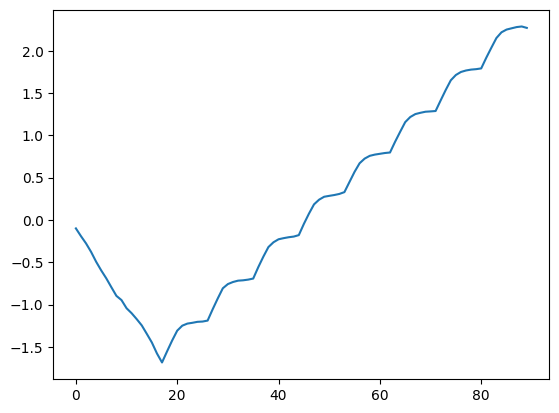

In [6]:
import matplotlib.pyplot as plt
plt.plot(total_rewards)